Import Python libraries. 

In [23]:
import numpy as np
from urllib.request import urlopen
import urllib
import matplotlib.pyplot as plt # Visuals
import seaborn as sns 
import sklearn as skl
import pandas as pd

from sklearn.cross_validation import train_test_split # Create training and test sets
from sklearn.neighbors import KNeighborsClassifier # Kth Nearest Neighbor
from sklearn.tree import DecisionTreeClassifier # Decision Trees
from sklearn.tree import export_graphviz # Extract Decision Tree visual
from sklearn.tree import tree 
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import roc_curve # ROC Curves
from sklearn.metrics import auc # AUC 
from urllib.request import urlopen # Get data from UCI Machine Learning Repository

Begin import of data into the notebook. Because we are working with three different datasets, we had to merge the data into one array. 

print(data) displays the entire dataframe. 

In [3]:
Cleveland_data_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
Hungarian_data_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
Switzerland_data_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data'
np.set_printoptions(threshold=np.nan)#makes it so that we can see a whole array when we output it

names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'heartdisease']
ClevelandHeartDisease = pd.read_csv(urlopen(Cleveland_data_URL), names = names)#gets Cleveland data
HungarianHeartDisease = pd.read_csv(urlopen(Hungarian_data_URL), names = names)#gets Hungary data
SwitzerlandHeartDisease = pd.read_csv(urlopen(Switzerland_data_URL), names = names)#gets Switzerland data
datatemp = [ClevelandHeartDisease, HungarianHeartDisease, SwitzerlandHeartDisease]#combines all arrays into a list
#heartDisease.set_index(['id_number'], inplace = True)
#I don't know what that did, but it was from Raoul's code and it was giving me bugs so I got rid of it
heartDisease = pd.concat(datatemp)#combines list into one array


We will begin the exploratory analysis of our dataset. 

We don't want to predict on all the variables so we are getting rid of 'ca', 'slope', and 'thal'.
For the variables we kept, there are still some "?" in the data, so we're going to replace them with a NAN. 

In [4]:
del heartDisease['ca']
del heartDisease['slope']
del heartDisease['thal']

heartDisease = heartDisease.replace('?', np.nan)
heartDisease.dtypes

age              int64
sex              int64
cp               int64
trestbps        object
chol            object
fbs             object
restecg         object
thalach         object
exang           object
oldpeak         object
heartdisease     int64
dtype: object

In [5]:
#loop to count the "?" per variable. More for interpretation but we don't really use it. 

count = 0
for item in heartDisease:
    for i in heartDisease[item]:
        count += (i == '?')

Now we can begin normalizing the data. First the data are all converted to float items and the function "normalize" does this!!!! 

In [6]:
for item in heartDisease: #converts everything to floats
    heartDisease[item] = pd.to_numeric(heartDisease[item])

def normalize(heartDisease, toNormalize): #normalizes 
    result = heartDisease.copy()
    for item in heartDisease.columns:
        if (item in toNormalize):
            max_value = heartDisease[item].max()
            min_value = heartDisease[item].min()
            result[item] = (heartDisease[item] - min_value) / (max_value - min_value)
    return result
toNormalize = ['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak'] #columns to normalize
heartDisease = normalize(heartDisease, toNormalize)
heartDisease = heartDisease.dropna()
heartDisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,heartdisease
0,0.000000,1,0.333333,0.416667,0.218905,0.0,2.0,0.961538,0.0,0.342105,0
1,0.021739,1,0.333333,0.333333,0.402985,0.0,0.0,0.769231,0.0,0.342105,0
3,0.043478,0,0.000000,0.750000,0.393035,0.0,1.0,0.846154,0.0,0.342105,0
4,0.065217,0,0.333333,0.166667,0.363184,0.0,1.0,0.692308,0.0,0.342105,0
5,0.086957,0,0.333333,0.208333,0.328358,0.0,0.0,0.807692,0.0,0.342105,0


This is a classification problem, so to simplify our project we are going to convert the predictor column into 1 for "heart disease is present" and 0 for "heart disease is not present."

Before, the scope of the disease ran from 0 - 5 for the intensity of the heart disease but this shit's too hard so we're going to replace it.

In [7]:
for i in range(1,5):
    heartDisease['heartdisease'] = heartDisease['heartdisease'].replace(i,1)
#heartDisease

Function from Ravi that tests for class imbalance in the data. Since we simplified the problem to solely 0's and 1's, this shouldn't be an issue. But let's check.

Class Imbalance refers to when a class within a data set is outnumbered by the other class (or classes). Reading documentation online, Class Imbalance is present when a class populates 10-20% of the data set.


In [8]:
def classImbalance(item):
    i = 0
    n = 0
    isPresent = 0 
    isNotPresent = 0
    for item in heartDisease[item]:
        if (item == 1):
            i += 1
        elif (item == 0):
            n += 1
    isPresent = (i/len(heartDisease)) * 100
    isNotPresent = (n/len(heartDisease)) * 100
    print("The percentage of heart disease present is: {0:.2f}%".format(isPresent)) 
    print("The percentage of heart disease not present is: {0:.2f}%".format(isNotPresent))
classImbalance('heartdisease')

The percentage of heart disease present is: 42.43%
The percentage of heart disease not present is: 57.57%


VISUALIZATION TIME

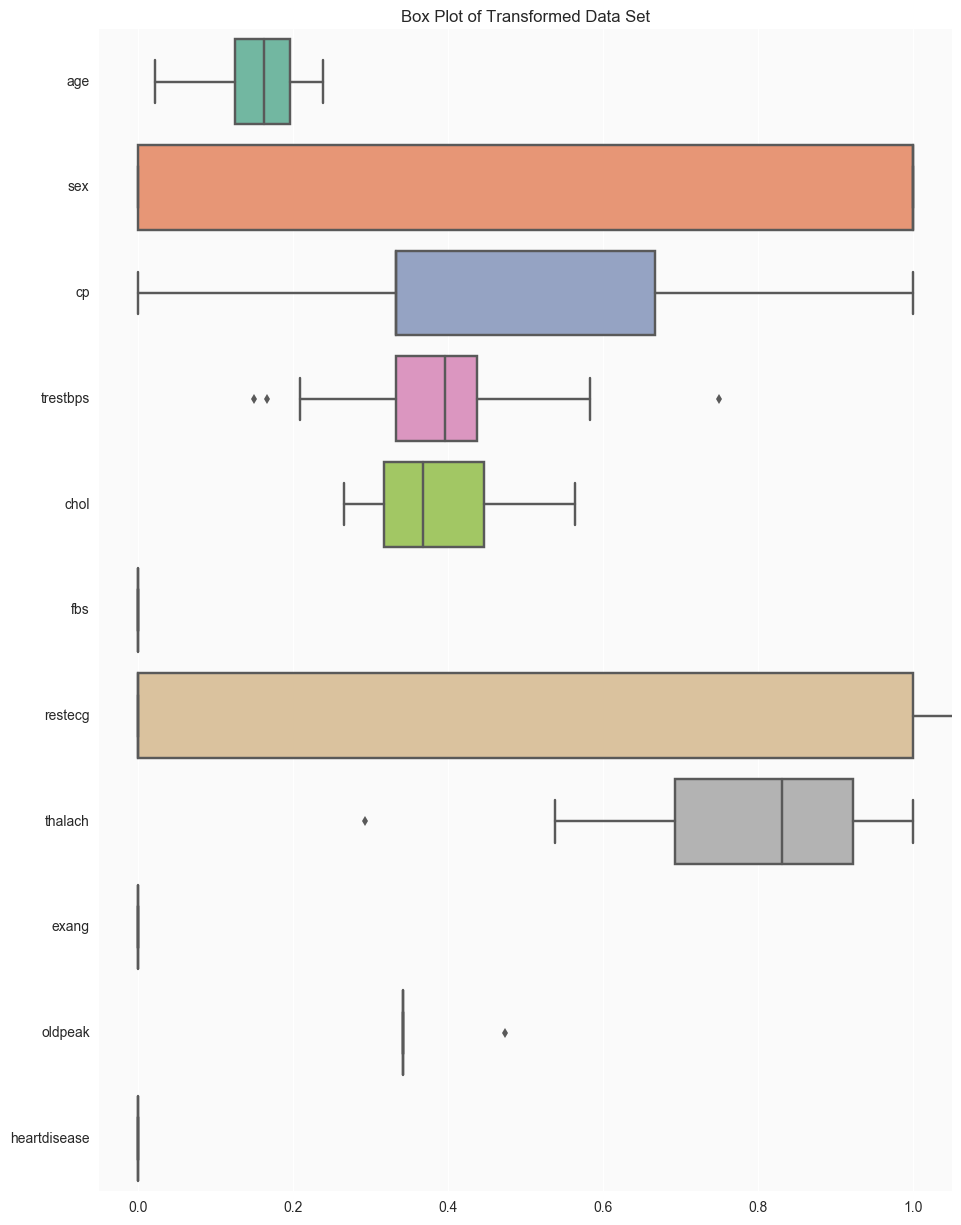

In [49]:
f, ax = plt.subplots(figsize=(11, 15))

ax.set_axis_bgcolor('#fafafa')
plt.title("Box Plot of Transformed Data Set")
ax.set(xlim=(-.05, 1.05))
ax = sns.boxplot(data = heartDisease[1:29], orient = 'h', palette = 'Set2')
plt.show()

Whoooo!!! Let's play with some algorithms. First, split the data into training and test sets. 

In [10]:
train, test = train_test_split(heartDisease, test_size = 0.20, random_state = 42)
# Create the training test omitting the diagnosis

training_set = train.ix[:, train.columns != 'heartdisease']
# Next we create the class set (Called target in Python Documentation)
class_set = train.ix[:, train.columns == 'heartdisease']

# Next we create the test set doing the same process as the training set
test_set = test.ix[:, test.columns != 'heartDisease']
test_class_set = test.ix[:, test.columns == 'heartdisease']

First applying random forest algorithm. 

In [11]:
fitRF = RandomForestClassifier(random_state = 42, 
                                criterion='gini',
                                n_estimators = 500,
                                max_features = 5)

In [12]:
fitRF.fit(train, class_set['heartdisease'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

We have to gather the variable importance. This is essential in decision trees and random forests for seeing which attributes played an important role in our algorithm. 

In [13]:
importancesRF = fitRF.feature_importances_
indicesRF = np.argsort(importancesRF)[::-1]
indicesRF

array([10,  8,  2,  9,  7,  4,  1,  0,  3,  5,  6])

In [14]:
namesInd = names[:12]
print("Feature ranking:")

for f in range(11):
    i = f
    print("%d. The feature '%s' has a Gini Importance of %f" % (f + 1, 
                                                                namesInd[indicesRF[i]], 
                                                                importancesRF[indicesRF[f]]))

Feature ranking:
1. The feature 'slope' has a Gini Importance of 0.752331
2. The feature 'exang' has a Gini Importance of 0.079926
3. The feature 'cp' has a Gini Importance of 0.075459
4. The feature 'oldpeak' has a Gini Importance of 0.051812
5. The feature 'thalach' has a Gini Importance of 0.013988
6. The feature 'chol' has a Gini Importance of 0.012730
7. The feature 'sex' has a Gini Importance of 0.004122
8. The feature 'age' has a Gini Importance of 0.003955
9. The feature 'trestbps' has a Gini Importance of 0.003850
10. The feature 'fbs' has a Gini Importance of 0.001082
11. The feature 'restecg' has a Gini Importance of 0.000746


Print the accuracy of the random forest. 


In [15]:
predictions_RF = fitRF.predict(test_set)
print(pd.crosstab(predictions_RF, test_class_set['heartdisease'], 
                  rownames=['Predicted Values'], 
                  colnames=['Actual Values']))

Actual Values      0   1
Predicted Values        
0                 64   0
1                  0  50


In [16]:
accuracy_RF = fitRF.score(test_set, test_class_set['heartdisease'])

print("Here is our mean accuracy on the test set:\n",
     '%.3f' % (accuracy_RF * 100), '%')

Here is our mean accuracy on the test set:
 100.000 %


Ooooh shit wtf. 100% is hella high......

In [17]:
# Here we calculate the test error rate!
test_error_rate_RF = 1 - accuracy_RF
print("The test error rate for our model is:\n",
     '%.3f' % (test_error_rate_RF * 100), '%')

The test error rate for our model is:
 0.000 %


In [18]:
#ROC curve calculation
fpr1, tpr1, _ = roc_curve(predictions_RF, test_class_set)
#AUC curve calcuation
auc_rf = auc(fpr1, tpr1)

Decision Tree Classifier (Richard's part)

In [41]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(train[['age', 'sex', 'cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak']], train['heartdisease'])
predictions_dt = dt.predict(test[['age', 'sex', 'cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak']])
predictright = 0
predictions.shape[0]
for i in range(0,predictions.shape[0]-1):
    if (predictions[i]== test.iloc[i][10]):
        predictright +=1
accuracy = predictright/predictions.shape[0]
accuracy

0.956140350877193

In [43]:
print("Table comparing actual vs. predicted values for our test set:\n",
     pd.crosstab(predictions_dt, test_class_set['heartdisease'], 
                  rownames=['Predicted Values'], 
                  colnames=['Actual Values']))

Table comparing actual vs. predicted values for our test set:
 Actual Values      0   1
Predicted Values        
0                 64   6
1                  0  44


In [47]:
#ROC curve calculation 
fpr2, tpr2, _ = roc_curve(predictions_dt, test_class_set)

#AUC curve calcuation
auc_dt = auc(fpr2, tpr2)

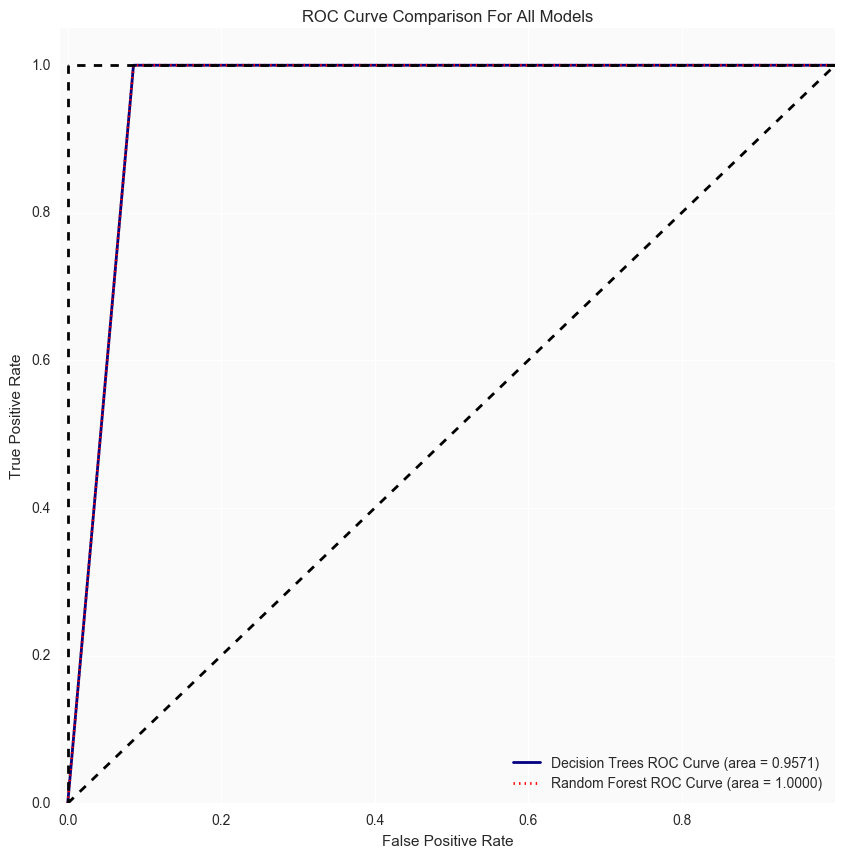

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(fpr1, tpr1,label='Decision Trees ROC Curve (area = %.4f)' % auc_dt, 
         color = 'navy', 
         linewidth=2)
plt.plot(fpr2, tpr2,label='Random Forest ROC Curve (area = %.4f)' % auc_rf, 
         color = 'red', 
         linestyle=':', 
         linewidth=2)


ax.set_axis_bgcolor('#fafafa')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison For All Models')
plt.legend(loc="lower right")

plt.show()

Since random forests are an extension of decision trees, we can see that the ROC curve is essentially the same and provides the same accuracy for both algorithms. 

###### Receiver Operating Characteristc Curve calculations 
The function roc_curve is for calculating the False Positive Rates and True Positive Rates for each model. 
The Area under the Curve was also calculated (in this case the curves are the ROC Curves).